## Modeul Import

In [57]:
# self defined Modules
from myModules.utils.data.DataLoader import DataLoader
from myModules.utils.merge.mergeOverPeriod import merge
from myModules.preprocess import cleaning, tagging, removeStopWords_ST, tokenizing_ST
from myModules.TopicModeling.LDA.ldaModeling import buildDTM, topicWords, visualizeLDA

# General Modules
import pandas as pd
import numpy as np

import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
import nltk
from nltk.tokenize import TreebankWordTokenizer
from apyori import apriori
from nltk import FreqDist
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_ST/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_ST/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_ST/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/ST/'
RESULT_2 = RESULT_ROOT + '/2시기/ST/'
RESULT_3 = RESULT_ROOT + '/3시기/ST/'

In [3]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1, mode='ST')
texts_2 = DataLoader(files_2, mode='ST')
texts_3 = DataLoader(files_3, mode='ST')

## PreProcess

### 3-1. Data Cleaning

In [4]:
cleaned_1 = cleaning(texts_1, mode='ST')
cleaned_2 = cleaning(texts_2, mode='ST')
cleaned_3 = cleaning(texts_3, mode='ST')

### 3-2. Tokenizing

In [5]:
tokenizer = TreebankWordTokenizer()

tokenized_1 = tokenizing_ST(cleaned_1, tokenizer)
tokenized_2 = tokenizing_ST(cleaned_2, tokenizer)
tokenized_3 = tokenizing_ST(cleaned_3, tokenizer)

### 3-3. Remove StopWords

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['would', 'could', 'might', 'need', 'can', 'must', \
    'e', 'one', 'two', 'upon', 'may', 'perhaps', 'living', 'seem', 'also', 'ii', 'ofthe',
    'also', 'much', 'therefore']

wo_stopword_1 = removeStopWords_ST(tokenized_1, stopwords, new_stopwords)
wo_stopword_2 = removeStopWords_ST(tokenized_2, stopwords, new_stopwords)
wo_stopword_3 = removeStopWords_ST(tokenized_3, stopwords, new_stopwords)

## 4. Topic Modeling

### 4-1. parameter tuning

- passes & iteration : 가능한 많은 것이 좋다.
- topic : 가설로 설정한 topic의 갯수
    1. Topic Coherence
        - 주제의 일관성 측정
        - 모델링이 잘 될수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨.
        - 높을수록 의미론적 일관성이 높다.
    2. Perplexity   
        - Coherence가 이 data에서 topic number가 늘어날수록 거의 같이 늘어나는 경향을 보임
        - 따라서 다른 평가기준도 함께 고려해야겠다는 생각에 추가

- Passes -> 30 이 가장 적절하다고 판단됨.


In [7]:
NUM_TOPIC_WORDS = 30
PASSES = 30
ITERATIONS = 400
EVAL_EVERY = None
random_state = 42

In [43]:
class bestTopicNum:
    def __init__(self, Corp, Dict, passes=30, iterations=400, eval_every=None, random_state=42):
        self.Corp, self.Dict = Corp, Dict
        self.passes = passes
        self.iterations = iterations
        self.eval_every = eval_every
        self.random_state = random_state
    
    def calc_coherence(self):
        self.coherences = []
        self.num_topics_c = []

        for i in tqdm(range(0, 21), desc='Topic Coherence'):
            if i==0 : ntopics = 2
            else : ntopics = i * 10
            
            model = models.ldamodel.LdaModel(self.Corp, id2word=self.Dict, num_topics=ntopics, iterations=self.iterations, passes=self.passes, \
                alpha='auto', eta='auto', eval_every=self.eval_every, random_state=self.random_state)
            
            cm = CoherenceModel(model=model, corpus=self.Corp, coherence='u_mass')
            coherence = cm.get_coherence()
            self.coherences.append(coherence)
            self.num_topics_c.append(ntopics)
    
    def calc_perplexity(self):
        self.perplexities = []
        self.num_topics_p = []

        for i in tqdm(range(0, 21), desc='Perpelxity'):
            if i==0 : ntopics = 2
            else : ntopics = i * 10
            
            model = models.ldamodel.LdaModel(self.Corp, id2word=self.Dict, num_topics=ntopics, iterations=self.iterations, passes=self.passes, \
                alpha='auto', eta='auto', eval_every=self.eval_every, random_state=self.random_state)
            
            perplexity = model.log_perplexity(self.Corp)
            self.perplexities.append(perplexity)
            self.num_topics_p.append(ntopics)
    
    def plot_coherence(self, title='Coherence per Topic Num', root='./'):
        plt.figure()

        plt.plot(self.num_topics_c, self.coherences)

        plt.xlabel('Topic Number')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()
    
    def plot_perplexity(self, title='Perplexity per Topic Num', root='./'):
        plt.figure()

        plt.plot(self.num_topics_p, self.perplexities)

        plt.xlabel('Topic Number')
        plt.ylabel('Perplexity')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

#### Period 1

In [44]:
Corp, Dict = buildDTM(wo_stopword_1)
topic = bestTopicNum(Corp, Dict, passes=PASSES, iterations=ITERATIONS, eval_every=EVAL_EVERY)

In [45]:
topic.calc_coherence()
topic.calc_perplexity()

Topic Coherence:   0%|          | 0/21 [00:00<?, ?it/s]

Perpelxity:   0%|          | 0/21 [00:00<?, ?it/s]

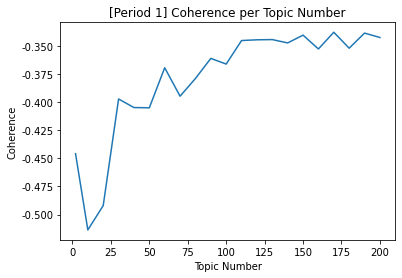

In [46]:
topic.plot_coherence('[Period 1] Coherence per Topic Number')

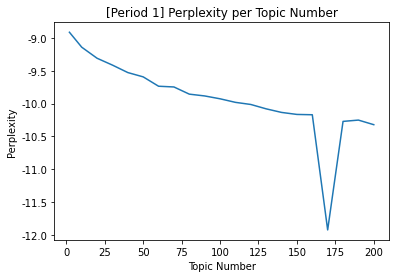

In [47]:
topic.plot_perplexity('[Period 1] Perplexity per Topic Number')

NUM_TOPICS

1. Topic Coherence
    - topic number가 증가할수록 coherence가 증가하는 것을 확인.
2. Perplexity
    - topic number가 175일떄 perplexity가 극소값을 가지는 것을 확인.

따라서 NUM_TOPICS를 175로 설정하는 것이 좋아보인다.

In [67]:
Corp, Dict = buildDTM(wo_stopword_1)

model = models.LdaModel(corpus=Corp, num_topics=60, id2word=Dict, random_state=random_state)

topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
34    -0.006762 -0.008693       1        1  52.966263
51    -0.001347 -0.003730       2        1  24.095483
5     -0.010170 -0.011996       3        1   5.528202
9      0.008310 -0.003557       4        1   4.807320
58     0.005723 -0.006759       5        1   4.504548
12     0.004972 -0.008308       6        1   2.555512
3      0.006436 -0.006213       7        1   2.467554
29    -0.010300 -0.000725       8        1   1.151889
30     0.007403  0.004430       9        1   0.913749
19    -0.019283 -0.005466      10        1   0.906992
47    -0.000936  0.008182      11        1   0.036158
32     0.002939  0.009359      12        1   0.020576
52    -0.002620 -0.002513      13        1   0.000953
42     0.008110 -0.005202      14        1   0.000953
35     0.002444  0.001502      15        1   0.000953
36     0.004357 -0.002672      16        1   0.000953
57    -0.001994  0.007301      17        1   0.000953
37    -0.006683  0.000084      18        1   0.000953
38    -0.003575  0.004822      19        1   0.000953
39    -0.000663 -0.001868      20        1   0.000953
40    -0.001330 -0.000703      21        1   0.000953
41    -0.005405  0.006013      22        1   0.000953
43    -0.001279  0.000333      23        1   0.000953
53     0.004816  0.006578      24        1   0.000953
44     0.000134 -0.006020      25        1   0.000953
45     0.010621 -0.008776      26        1   0.000953
56    -0.000421  0.003241      27        1   0.000953
46     0.002942  0.001607      28        1   0.000953
55    -0.002785  0.001860      29        1   0.000953
54     0.008923 -0.004881      30        1   0.000953
49    -0.001007  0.000272      31        1   0.000953
50     0.001114  0.003414      32        1   0.000953
48     0.008642  0.005238      33        1   0.000953
0      0.001564  0.000287      34        1   0.000953
33    -0.001715 -0.002643      35        1   0.000953
31    -0.006125 -0.001770      36        1   0.000953
2      0.012067  0.002238      37        1   0.000953
4     -0.005069  0.001962      38        1   0.000953
6     -0.001612 -0.004850      39        1   0.000953
7      0.001333  0.003979      40        1   0.000953
8      0.001001 -0.004062      41        1   0.000953
10     0.001295  0.003173      42        1   0.000953
11    -0.003197 -0.003488      43        1   0.000953
13    -0.002438  0.003572      44        1   0.000953
14    -0.006686  0.009096      45        1   0.000953
15     0.001815 -0.006662      46        1   0.000953
16    -0.005875 -0.009467      47        1   0.000953
17     0.002634 -0.000755      48        1   0.000953
18    -0.005094  0.009302      49        1   0.000953
20    -0.004386  0.005211      50        1   0.000953
21     0.000563 -0.005207      51        1   0.000953
22     0.003735  0.002860      52        1   0.000953
23     0.003493  0.003868      53        1   0.000953
24    -0.003615  0.000943      54        1   0.000953
25     0.001873  0.002209      55        1   0.000953
26     0.004357  0.004387      56        1   0.000953
27     0.000056  0.002594      57        1   0.000953
28     0.005376  0.001608      58        1   0.000953
1      0.000442 -0.000816      59        1   0.000953
59    -0.007117  0.006279      60        1   0.000953, topic_info=          Term        Freq       Total Category  logprob  loglift
3863    soviet  154.000000  154.000000  Default  30.0000  30.0000
1615       war  115.000000  115.000000  Default  29.0000  29.0000
87        army   99.000000   99.000000  Default  28.0000  28.0000
49    american   98.000000   98.000000  Default  27.0000  27.0000
948        new   84.000000   84.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1515      time    0.000434   60.601686  Topic60  -6.5219  -0.2854
1661     world    0.000374   38.397698  Topic60  -6.6701   0.0227
519      first 

#### Period 2

In [ ]:
Corp, Dict = buildDTM(wo_stopword_2)
topic = bestTopicNum(Corp, Dict, passes=PASSES, iterations=ITERATIONS, eval_every=EVAL_EVERY)

In [ ]:
best_k = topic.calc_best_k()

print(f'[Best Topic Num] {best_k} (in [2, 90])')

In [ ]:
topic.plot_coherence('[Period 2] Coherence per Topic Number')

#### Period 3

In [ ]:
Corp, Dict = buildDTM(wo_stopword_3)
topic = bestTopicNum(Corp, Dict, passes=PASSES, iterations=ITERATIONS, eval_every=EVAL_EVERY)

In [ ]:
best_k = topic.calc_best_k()

print(f'[Best Topic Num] {best_k} (in [2, 90])')

In [ ]:
topic.plot_coherence('[Period 3] Coherence per Topic Number')